In [10]:
import sys
sys.path.append('..')

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils.timescale_connector import TimescaleConnector


In [13]:
data = TimescaleConnector.query_ohlcv_daily("ACB")

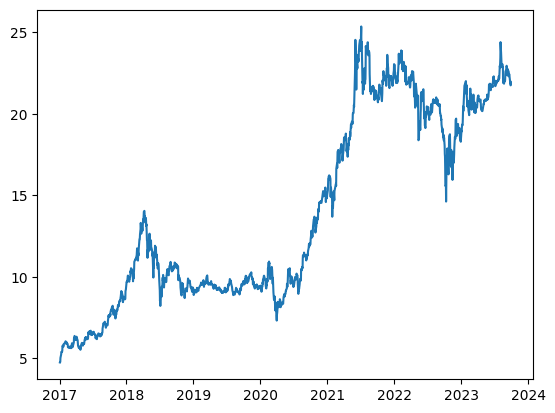

In [14]:
# EDA
data["date"] = pd.to_datetime(data["date"])

plt.plot(data["date"], data["close"])

In [16]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    df.set_index('date', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'close(t-{i})'] = df['close'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 5
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,open,high,low,close,volume,symbol,close(t-1),close(t-2),close(t-3),close(t-4),close(t-5)
date,,,,,,,,,,,
2017-01-10,5.20,5.28,5.08,5.25,942499,ACB,5.20,5.03,4.78,4.78,4.75
2017-01-11,5.20,5.45,5.20,5.40,1447461,ACB,5.25,5.20,5.03,4.78,4.78
2017-01-12,5.38,5.55,5.33,5.40,1158392,ACB,5.40,5.25,5.20,5.03,4.78
2017-01-13,5.35,5.50,5.30,5.38,1230784,ACB,5.40,5.40,5.25,5.20,5.03
2017-01-16,5.38,5.45,5.33,5.45,575469,ACB,5.38,5.40,5.40,5.25,5.20
...,...,...,...,...,...,...,...,...,...,...,...
2023-09-25,22.30,22.35,22.00,22.00,7623000,ACB,22.30,22.40,22.45,22.30,22.45
2023-09-26,22.05,22.25,21.85,21.90,9404200,ACB,22.00,22.30,22.40,22.45,22.30
2023-09-27,21.90,22.00,21.75,22.00,5685000,ACB,21.90,22.00,22.30,22.40,22.45
